cpu


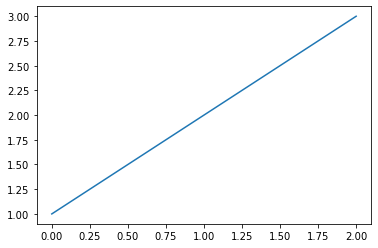

In [2]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env import RealExpEnv
from RL.sac import sac_agent, ReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

succeed to connect
(128, 128)


"\ntemplate_path = 'template.png'\n#cv2.imwrite(template_path, template)\n"

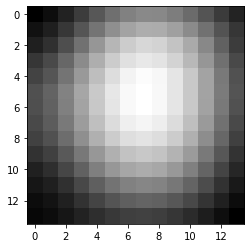

In [242]:
##Define anchor template
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (4,4), 14, 14
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)


In [243]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
im_size_nm = 10.027
DactoA = float(createc_controller.stm.getparam('Dacto[A]xy'))
Gain = float(createc_controller.stm.getparam("GainX"))
print('gain:', Gain)
offset_x = -float(createc_controller.stm.getparam('OffsetX'))*DactoA*Gain/10
offset_y = -float(createc_controller.stm.getparam('OffsetY'))*DactoA*Gain/10
print(offset_x, offset_y)
print(float(createc_controller.stm.getparam('PlanDx')), float(createc_controller.stm.getparam('PlanDy')))
offset_x -= float(createc_controller.stm.getparam('PlanDx'))
offset_y -= float(createc_controller.stm.getparam('PlanDy'))

print(offset_x, offset_y)
offset_nm = np.array([190.386,-13.5])
pixel = 128
manip_limit_nm = np.array([189, 195, -11, -5]) #[left, right, up, down]
template_max_y = 25
template_min_x = None
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, template_min_x, scan_mV, max_len)


gain: 10.0
191.53506700000003 -13.581448
-0.09 -0.138
191.62506700000003 -13.443448
succeed to connect


In [209]:
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000
#initialize sac_agent
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=0.0973)
#load pretrained parameters
agent.critic.load_state_dict(torch.load('training_4/reward_2_critic_{}.pth'.format(3000)))
agent.policy.load_state_dict(torch.load('training_4/reward_2_policy_{}.pth'.format(3000)))
agent.alpha = torch.load('training_4/reward_2_alpha_{}.pth'.format(3000))
memory = ReplayMemory(replay_size)
#, map_location=torch.device('cpu')

In [10]:
episode_memory = Episode_Memory()

In [157]:
scores_array = []
avg_scores_array = []

alpha = []
temp_nm = []
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = 5
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    global added_episode
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward = 0
        episode_steps = 0
        done = False
        state, info = env.reset()
        show_reset(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                   env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh)
        print('old value:',env.old_value)
        #print(env.atom_absolute_nm)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        temp_nm.append(env.template_nm)
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state)
            atom_absolute_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print(reward)
            #print(action, done, reward)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            state=next_state
            show_step(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                      info['start_nm']+atom_absolute_nm, info['end_nm']+atom_absolute_nm,
                      env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, 
                      env.template_nm, env.template_wh, action[4]*env.max_mvolt, 
                      action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
            print('template_nm',env.template_nm)
            temp_nm.append(env.template_nm)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory('training_4')
                new_destination_absolute_nm = None
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('atom moved by:', np.linalg.norm(atom_to_start))
                print('Episode reward:', episode_reward)
                show_done(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh, reward, new_destination_absolute_nm)
                
                break
                
        if (len(memory)>batch_size):
            if i_episode>100:
                train_pi = True
            else:
                train_pi = True
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                #c_k = memory.__len__()
                print('TRAINING!')
                agent.update_parameters(memory, batch_size, c_k, train_pi)
        
        scores_array.append(episode_reward)
        if len(scores_array)>100:
            avg_scores_array.append(np.mean(scores_array[-100:]))
        else:
            avg_scores_array.append(np.mean(scores_array))
        print(agent.alpha)
        alpha.append(agent.alpha)
        
        if (i_episode+1)%2==0:
            plot_graph(scores_array,avg_scores_array)
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), 'training_4/reward_2_critic_{}.pth'.format(i_episode))
            torch.save(agent.policy.state_dict(), 'training_4/reward_2_policy_{}.pth'.format(i_episode))
            torch.save(agent.alpha, 'training_4/reward_2_alpha_{}.pth'.format(i_episode))


In [248]:
env.atom_absolute_nm = None

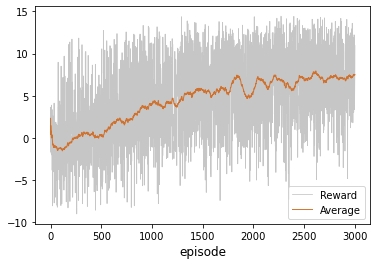

Episode: 3000
goal_nm: 1.4532534078746775


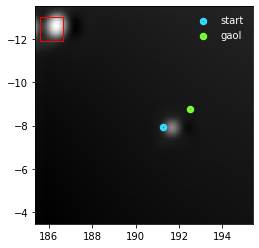

old value: 0.011891458702653209
step: 0
72 75 99 72
The scan will take 19.7 seconds
atom moves by: 1.766872068323623
value: 3.111664129210148
2.899772670507495


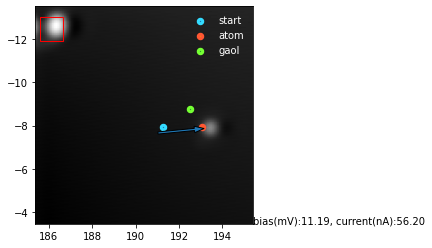

template_nm [185.56826297 -12.99080828]
step: 1
101 75 89 60
value: 3.111664129210148
-0.20000000000000018


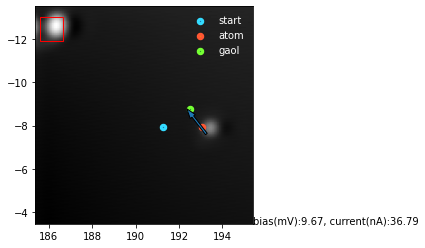

template_nm [185.56826297 -12.99080828]
step: 2
102 75 97 63
The scan will take 19.7 seconds
atom moves by: 1.7598793835184428
value: 6.509437939761673
3.1977738105515248


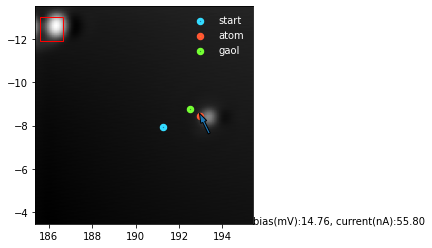

template_nm [185.56826297 -12.99080828]
step: 3
98 60 92 62
value: 6.509437939761673
-0.20000000000000018


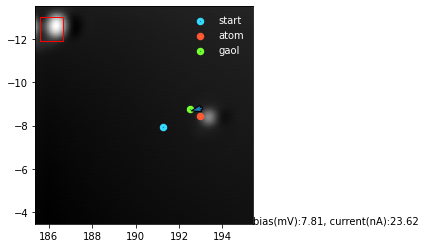

template_nm [185.56826297 -12.99080828]
step: 4
95 70 89 51
The scan will take 19.7 seconds
value: 6.542406326513428
-0.16703161324824567


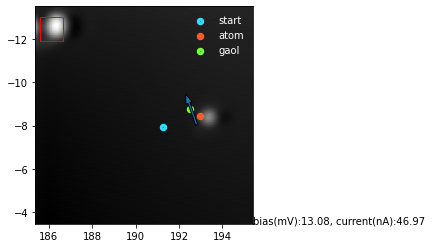

template_nm [185.56826297 -12.99080828]
atom moved by: 1.7574780435531734
Episode reward: 5.530514867810774


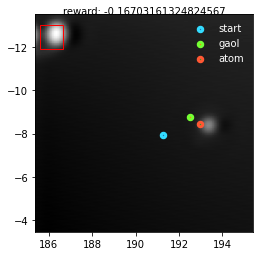

TRAINING!
TRAINING!
TRAINING!
TRAINING!
TRAINING!
tensor([0.1171], device='cuda:0')
Episode: 3001
goal_nm: 0.31435403820598345


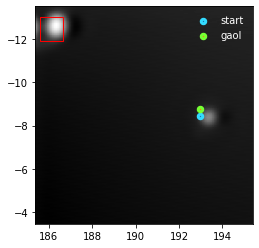

old value: 7.297086825658626
step: 0
95 69 105 71
The scan will take 19.7 seconds


KeyboardInterrupt: 

In [249]:
sac_train(max_steps=max_len, episode_start = 0,num_episodes = 1000)

@1700 change max_ep_len from 50 to 5
@1826 change cut off distance from 0.28 nm to 0.14 nm
@1850 pause for taking bench mark and change cutoff distance to 0.1 nm
@2092 change upper cutoff from self.goal_nm to 1.5*self.goal_nm
@2106 change to 128 pixel
@2138 chnge to check_similarity with absolute coordinates
@2216 system crash, restart computer and tip

In [10]:
def save_buffer(buffer):
    state, action, reward, next_state, done = map(np.stack,zip(*memory.buffer))
    np.save('state.npy',state)
    np.save('action.npy',action)
    np.save('reward.npy',reward)
    np.save('next_state.npy', next_state)
    np.save('done.npy', done)
save_buffer(memory.buffer)